In [15]:
import numpy as np
import pandas as pd
import os, glob
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import itertools

In [16]:
# Grab unique ID of subjects from name of the file
def getFilename(full_dir):
    _,filename = full_dir.split('\\')
    print(filename)
    subject,_,_,_,_= filename.split('_')
    return str(subject)

In [17]:
# Created empty arrays to collects by the categories
segm_byInst = []

Noninfiltrated_flair_byInst = []
Noninfiltrated_t1_byInst = []
Noninfiltrated_t1ce_byInst = []
Noninfiltrated_t2_byInst = []
Noninfiltrated_adc_byInst = []

Infiltrated_flair_byinst = []
Infiltrated_t1_byinst = []
Infiltrated_t1ce_byinst = []
Infiltrated_t2_byinst = []
Infiltrated_adc_byinst = []

In [18]:
# Call first institution subjects
first_seg_dir = 'segmentation images directory'
first_far_dir = 'collected Far patches'
first_near_dir = 'collected Near patches'

# Collects all the files for first institutions
first_segm_dir = sorted(glob.glob(os.path.join(first_seg_dir, "*_segm*.nii.gz")))

first_far_flair_dir = sorted(glob.glob(os.path.join(first_far_dir, "*_flairPatch*.nii.gz"))) 
first_far_t1_dir = sorted(glob.glob(os.path.join(first_far_dir, "*_t1Patch*.nii.gz"))) 
first_far_t1ce_dir = sorted(glob.glob(os.path.join(first_far_dir, "*_t1cePatch*.nii.gz"))) 
first_far_t2_dir = sorted(glob.glob(os.path.join(first_far_dir, "*_t2Patch*.nii.gz"))) 
first_far_adc_dir = sorted(glob.glob(os.path.join(first_far_dir, "*_adcPatch*.nii.gz"))) 

first_near_flair_dir = sorted(glob.glob(os.path.join(first_near_dir, "*_flairPatch*.nii.gz"))) 
first_near_t1_dir = sorted(glob.glob(os.path.join(first_near_dir, "*_t1Patch*.nii.gz"))) 
first_near_t1ce_dir = sorted(glob.glob(os.path.join(first_near_dir, "*_t1cePatch*.nii.gz"))) 
first_near_t2_dir = sorted(glob.glob(os.path.join(first_near_dir, "*_t2Patch*.nii.gz"))) 
first_near_adc_dir = sorted(glob.glob(os.path.join(first_near_dir, "*_adcPatch*.nii.gz"))) 

# Added to the array by categories
segm_byInst.append(first_segm_dir)

Noninfiltrated_flair_byInst.append(first_far_flair_dir)
Noninfiltrated_t1_byInst.append(first_far_t1_dir)
Noninfiltrated_t1ce_byInst.append(first_far_t1ce_dir)
Noninfiltrated_t2_byInst.append(first_far_t2_dir)
Noninfiltrated_adc_byInst.append(first_far_adc_dir)

Infiltrated_flair_byinst.append(first_near_flair_dir)
Infiltrated_t1_byinst.append(first_near_t1_dir)
Infiltrated_t1ce_byinst.append(first_near_t1ce_dir)
Infiltrated_t2_byinst.append(first_near_t2_dir)
Infiltrated_adc_byinst.append(first_near_adc_dir)

In [19]:
# Call second institutino subjects
second_seg_dir = 'segmentation images directory'
second_far_dir = 'collected Far patches'
second_near_dir = 'collected Near patches'

# Collects all the files for second institutions
second_segm_dir = sorted(glob.glob(os.path.join(second_seg_dir, "*_segm*.nii.gz")))

second_far_flair_dir = sorted(glob.glob(os.path.join(second_far_dir, "*_flairPatch*.nii.gz"))) 
second_far_t1_dir = sorted(glob.glob(os.path.join(second_far_dir, "*_t1Patch*.nii.gz"))) 
second_far_t1ce_dir = sorted(glob.glob(os.path.join(second_far_dir, "*_t1cePatch*.nii.gz"))) 
second_far_t2_dir = sorted(glob.glob(os.path.join(second_far_dir, "*_t2Patch*.nii.gz"))) 
second_far_adc_dir = sorted(glob.glob(os.path.join(second_far_dir, "*_adcPatch*.nii.gz"))) 

second_near_flair_dir = sorted(glob.glob(os.path.join(second_near_dir, "*_flairPatch*.nii.gz"))) 
second_near_t1_dir = sorted(glob.glob(os.path.join(second_near_dir, "*_t1Patch*.nii.gz"))) 
second_near_t1ce_dir = sorted(glob.glob(os.path.join(second_near_dir, "*_t1cePatch*.nii.gz"))) 
second_near_t2_dir = sorted(glob.glob(os.path.join(second_near_dir, "*_t2Patch*.nii.gz"))) 
second_near_adc_dir = sorted(glob.glob(os.path.join(second_near_dir, "*_adcPatch*.nii.gz")))

segm_byInst.append(second_segm_dir)

Noninfiltrated_flair_byInst.append(second_far_flair_dir)
Noninfiltrated_t1_byInst.append(second_far_t1_dir)
Noninfiltrated_t1ce_byInst.append(second_far_t1ce_dir)
Noninfiltrated_t2_byInst.append(second_far_t2_dir)
Noninfiltrated_adc_byInst.append(second_far_adc_dir)

Infiltrated_flair_byinst.append(second_near_flair_dir)
Infiltrated_t1_byinst.append(second_near_t1_dir)
Infiltrated_t1ce_byinst.append(second_near_t1ce_dir)
Infiltrated_t2_byinst.append(second_near_t2_dir)
Infiltrated_adc_byinst.append(second_near_adc_dir)

In [ ]:
# You may add more institutinos as you wish

In [24]:
# Load nifti files into numpy array
def LoadingImage(dir):
    
    nifti_image = nib.load(dir)
    image = np.asarray(nifti_image.dataobj)
    header = nifti_image.header
    imgaffine = nifti_image.affine
    
    return image, header, imgaffine

In [25]:
# Load images and stack them for training to sahpe of (5,5,5,5) 
def load_and_stack_image_dirs(dirs):
    stacked_images = []
    for i in range(len(dirs[0])):  # Assume all lists have same length
        # Load images from each directory, then stack along a new dimension
        images = [nib.load(dir[i]).get_fdata() for dir in dirs]
        for image in images:
            if image.shape != (5, 5, 5):
                print(f'error: ' + dirs[0][i])
                print(image.shape)
        stacked_image = np.stack(images, axis=0)  # Now each image is treated as a separate channel
        stacked_images.append(stacked_image)

    return np.array(stacked_images)

In [26]:
# Simple 3D CNN network
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(5, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 5 * 5 * 5, 128)  # 128 is an arbitrary choice, feel free to change
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # apply conv1, then ReLU
        x = torch.relu(self.conv2(x))  # apply conv2, then ReLU
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = torch.relu(self.fc1(x))  # apply first fully connected layer, then ReLU
        x = self.dropout(x)  # apply dropout
        x = self.fc2(x)  # apply second fully connected layer
        return x

In [27]:
subjects = ['first_institution', 'second_institution']

In [ ]:
segm_byInst = []

Noninfiltrated_flair_byInst = []
Noninfiltrated_t1_byInst = []
Noninfiltrated_t1ce_byInst = []
Noninfiltrated_t2_byInst = []
Noninfiltrated_adc_byInst = []

Infiltrated_flair_byinst = []
Infiltrated_t1_byinst = []
Infiltrated_t1ce_byinst = []
Infiltrated_t2_byinst = []
Infiltrated_adc_byinst = []

(11892, 5, 5, 5, 5)
(11892,)
Epoch 1/1000, Training Loss: 0.5386043205542665, Validation Loss: 0.48773370482729156, Validation Accuracy: 76.82174887892377%
Epoch 2/1000, Training Loss: 0.46431841153558523, Validation Loss: 0.4799762733046784, Validation Accuracy: 75.98094170403587%
Epoch 3/1000, Training Loss: 0.4093160143197155, Validation Loss: 0.39637494691952463, Validation Accuracy: 82.34304932735425%
Epoch 4/1000, Training Loss: 0.38018953958937396, Validation Loss: 0.36568532551684724, Validation Accuracy: 84.61322869955157%
Epoch 5/1000, Training Loss: 0.34117265331653623, Validation Loss: 0.3143081589530936, Validation Accuracy: 86.88340807174887%
Epoch 6/1000, Training Loss: 0.2998599826059735, Validation Loss: 0.29866956394884087, Validation Accuracy: 87.35986547085201%
Epoch 7/1000, Training Loss: 0.27804414486787826, Validation Loss: 0.2609376982355599, Validation Accuracy: 89.40582959641256%
Epoch 8/1000, Training Loss: 0.2560099266297872, Validation Loss: 0.2858673621286

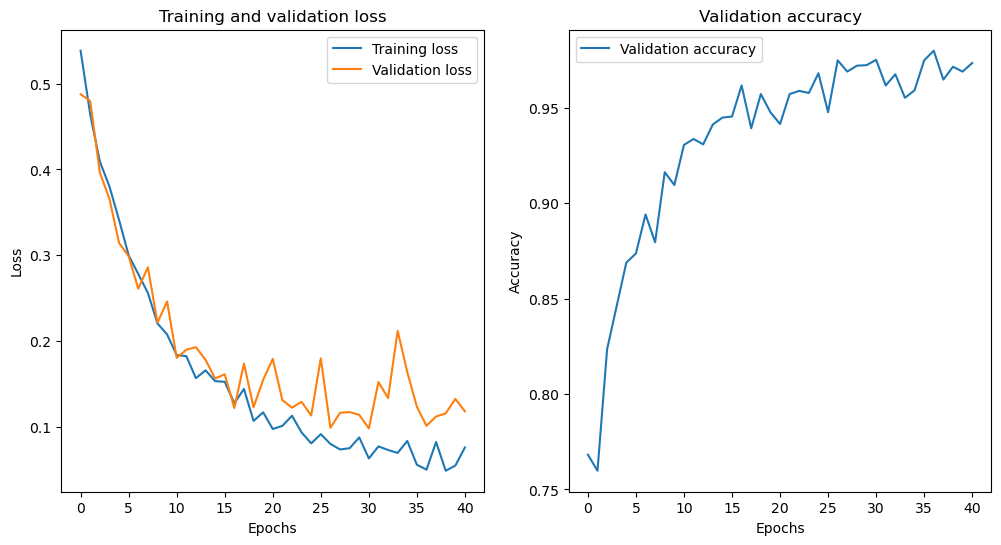

(18742, 5, 5, 5, 5)
(18742,)
Epoch 1/1000, Training Loss: 0.5100862734019757, Validation Loss: 0.41748900673436845, Validation Accuracy: 81.16663702649831%
Epoch 2/1000, Training Loss: 0.4165279630389882, Validation Loss: 0.3727140897800299, Validation Accuracy: 83.1762404410457%
Epoch 3/1000, Training Loss: 0.38823116104595545, Validation Loss: 0.3412747551390732, Validation Accuracy: 84.99021874444247%
Epoch 4/1000, Training Loss: 0.35293626170151116, Validation Loss: 0.33780189839572733, Validation Accuracy: 85.22141205762048%
Epoch 5/1000, Training Loss: 0.32308365746242246, Validation Loss: 0.28338014184158633, Validation Accuracy: 88.28027743197582%
Epoch 6/1000, Training Loss: 0.30231133332339727, Validation Loss: 0.3010451837485148, Validation Accuracy: 86.16396941134626%
Epoch 7/1000, Training Loss: 0.27696351766949745, Validation Loss: 0.30082168375586416, Validation Accuracy: 87.64004979548284%
Epoch 8/1000, Training Loss: 0.25750058636114725, Validation Loss: 0.254868843915

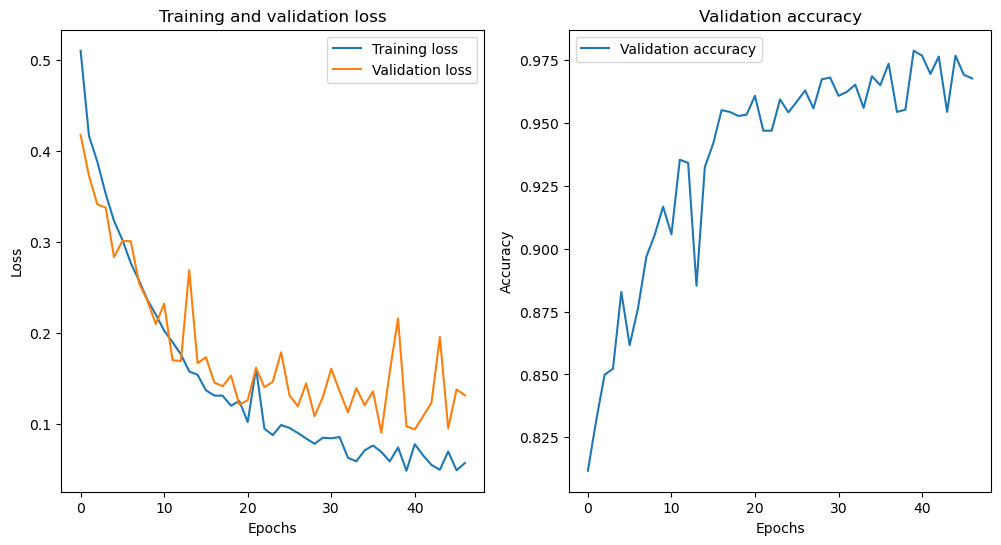

(20734, 5, 5, 5, 5)
(20734,)
Epoch 1/1000, Training Loss: 0.4855538503008398, Validation Loss: 0.44316540455450437, Validation Accuracy: 79.92284198681884%
Epoch 2/1000, Training Loss: 0.39639406804701044, Validation Loss: 0.3552195516757303, Validation Accuracy: 84.50409901945025%
Epoch 3/1000, Training Loss: 0.35890158760619845, Validation Loss: 0.3344380148425507, Validation Accuracy: 86.1115576273911%
Epoch 4/1000, Training Loss: 0.3291416628458558, Validation Loss: 0.3216457444513672, Validation Accuracy: 85.85436425012057%
Epoch 5/1000, Training Loss: 0.28917479028900683, Validation Loss: 0.27122435473135476, Validation Accuracy: 88.71564057225527%
Epoch 6/1000, Training Loss: 0.27696764012511477, Validation Loss: 0.26980040963154983, Validation Accuracy: 88.47452178106414%
Epoch 7/1000, Training Loss: 0.2537946529637218, Validation Loss: 0.3115733095581205, Validation Accuracy: 87.59041954669668%
Epoch 8/1000, Training Loss: 0.2400991899507671, Validation Loss: 0.272805267995209

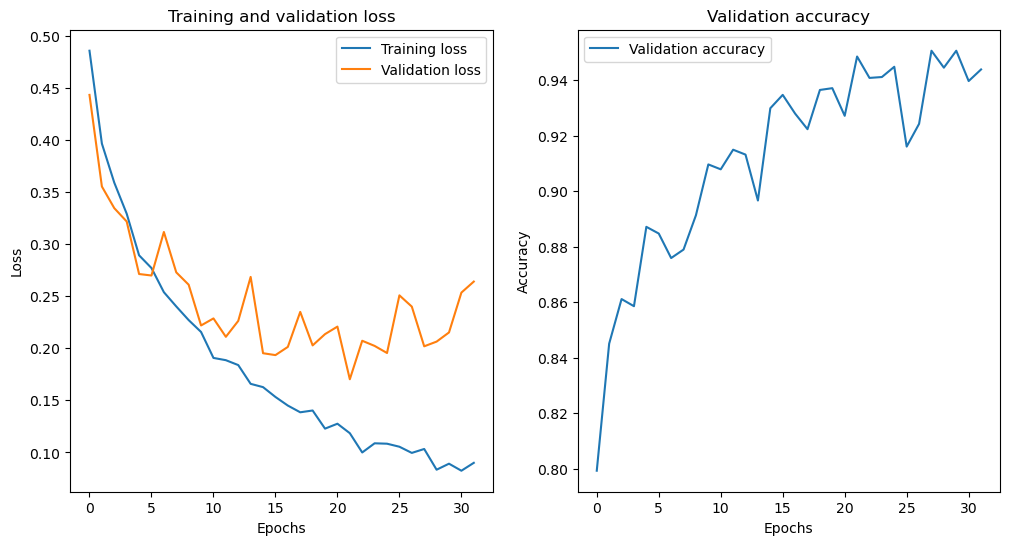

(17978, 5, 5, 5, 5)
(17978,)
Epoch 1/1000, Training Loss: 0.5597727455321837, Validation Loss: 0.4774182791099746, Validation Accuracy: 76.97441601779755%
Epoch 2/1000, Training Loss: 0.4606053130713018, Validation Loss: 0.4021674321424326, Validation Accuracy: 82.23952539859103%
Epoch 3/1000, Training Loss: 0.40202696155638373, Validation Loss: 0.4054731971545685, Validation Accuracy: 81.01594364108269%
Epoch 4/1000, Training Loss: 0.38028088239467733, Validation Loss: 0.3700288631374667, Validation Accuracy: 82.44345569150909%
Epoch 5/1000, Training Loss: 0.35153799215769527, Validation Loss: 0.31514075368686895, Validation Accuracy: 86.35520949202818%
Epoch 6/1000, Training Loss: 0.3254446452140354, Validation Loss: 0.30360095875238524, Validation Accuracy: 86.00296625880608%
Epoch 7/1000, Training Loss: 0.292394079862037, Validation Loss: 0.2983590368864804, Validation Accuracy: 86.63329625509826%
Epoch 8/1000, Training Loss: 0.2739384103580609, Validation Loss: 0.2511278816978254,

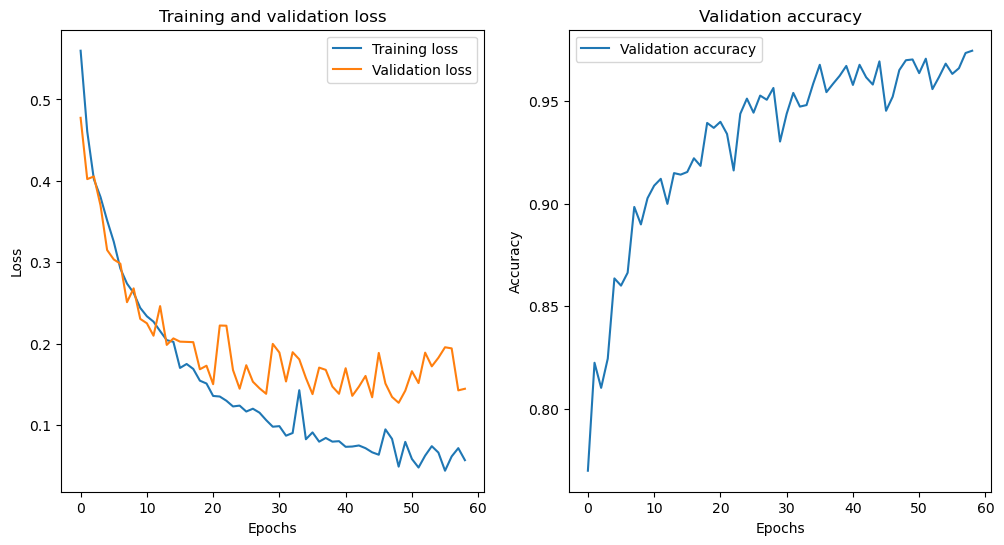

(22508, 5, 5, 5, 5)
(22508,)
Epoch 1/1000, Training Loss: 0.4962457000150293, Validation Loss: 0.4169572613974835, Validation Accuracy: 81.40085887753591%
Epoch 2/1000, Training Loss: 0.397656313870764, Validation Loss: 0.355467714316456, Validation Accuracy: 84.48097142010958%
Epoch 3/1000, Training Loss: 0.36252825636851604, Validation Loss: 0.37751239046771473, Validation Accuracy: 82.82244928180069%
Epoch 4/1000, Training Loss: 0.3375098245889705, Validation Loss: 0.29603779145095926, Validation Accuracy: 87.73878276321635%
Epoch 5/1000, Training Loss: 0.31668823094764337, Validation Loss: 0.3092618248916405, Validation Accuracy: 86.0950688582852%
Epoch 6/1000, Training Loss: 0.2920172779466295, Validation Loss: 0.3593539416296826, Validation Accuracy: 85.62120539019695%
Epoch 7/1000, Training Loss: 0.2710236727756443, Validation Loss: 0.2735079890887647, Validation Accuracy: 88.24226269806013%
Epoch 8/1000, Training Loss: 0.26056141706779223, Validation Loss: 0.23723755721399126, 

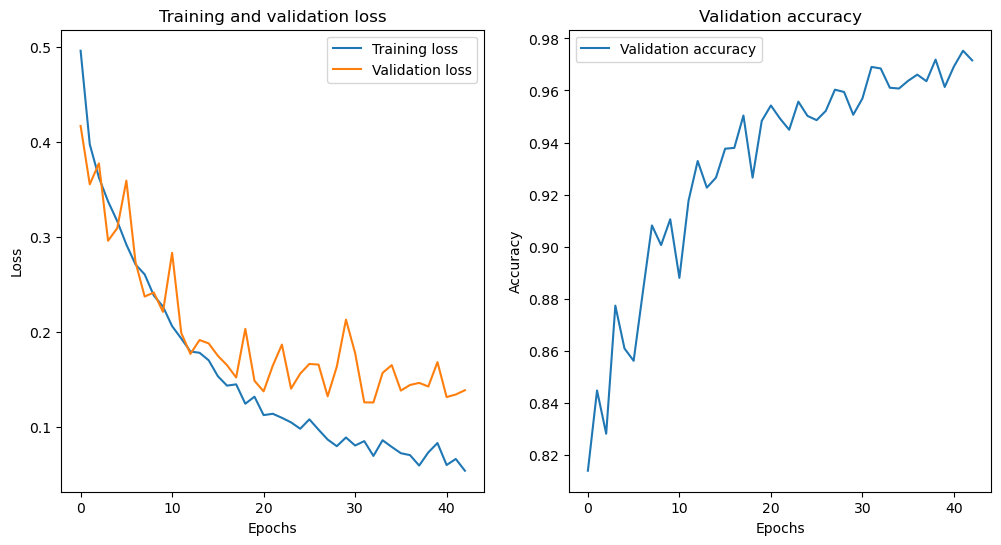

(22336, 5, 5, 5, 5)
(22336,)
Epoch 1/1000, Training Loss: 0.5042347045489616, Validation Loss: 0.5204947632081753, Validation Accuracy: 75.03357707804805%
Epoch 2/1000, Training Loss: 0.41347275733003097, Validation Loss: 0.4408675629938986, Validation Accuracy: 77.57051186390092%
Epoch 3/1000, Training Loss: 0.3691495872485491, Validation Loss: 0.3673749262009145, Validation Accuracy: 83.67407849574691%
Epoch 4/1000, Training Loss: 0.33730085345331756, Validation Loss: 0.3433571617721373, Validation Accuracy: 85.36039397104909%
Epoch 5/1000, Training Loss: 0.3122585517238132, Validation Loss: 0.33048581013673817, Validation Accuracy: 86.16624384420236%
Epoch 6/1000, Training Loss: 0.2972245519382761, Validation Loss: 0.3015130194246342, Validation Accuracy: 87.12132517534697%
Epoch 7/1000, Training Loss: 0.275047726447814, Validation Loss: 0.2719096656986523, Validation Accuracy: 88.85241008804657%
Epoch 8/1000, Training Loss: 0.25633433921470217, Validation Loss: 0.25356178513565825,

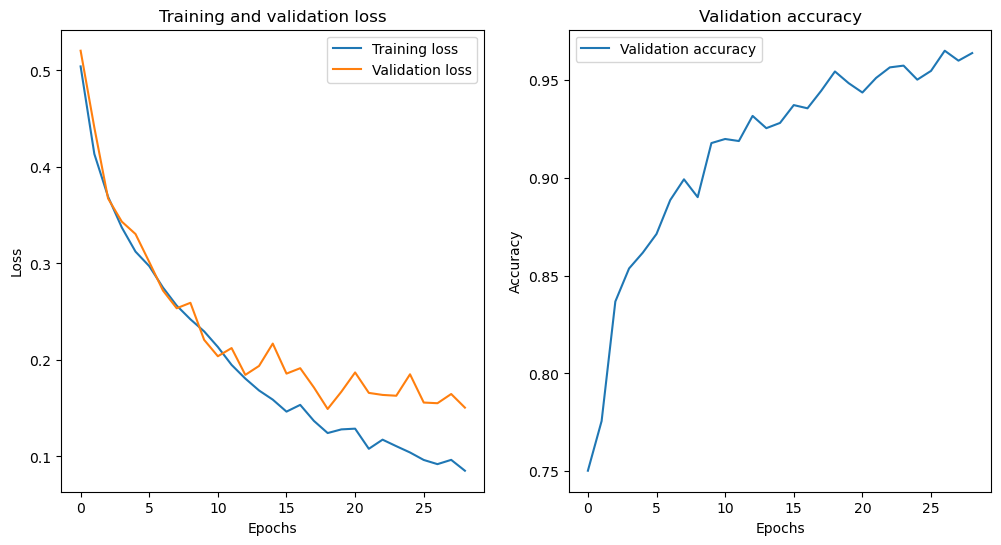

In [28]:
# number of institutions you use
n = 2

# Iterate by each institution and perform leave-one-site-out training. 
for k in range(n):
    segm_combine = segm_byInst[:k] + segm_byInst[k+1:]

    Noninfiltrated_flair_combine = Noninfiltrated_flair_byInst[:k] + Noninfiltrated_flair_byInst[k+1:]
    Noninfiltrated_t1_combine = Noninfiltrated_t1_byInst[:k] + Noninfiltrated_t1_byInst[k+1:]
    Noninfiltrated_t1ce_combine = Noninfiltrated_t1ce_byInst[:k] + Noninfiltrated_t1ce_byInst[k+1:]
    Noninfiltrated_t2_combine = Noninfiltrated_t2_byInst[:k] + Noninfiltrated_t2_byInst[k+1:]
    Noninfiltrated_adc_combine = Noninfiltrated_adc_byInst[:k] + Noninfiltrated_adc_byInst[k+1:]

    Infiltrated_flair_combine = Infiltrated_flair_byinst[:k] + Infiltrated_flair_byinst[k+1:]
    Infiltrated_t1_combine = Infiltrated_t1_byinst[:k] + Infiltrated_t1_byinst[k+1:]
    Infiltrated_t1ce_combine = Infiltrated_t1ce_byinst[:k] + Infiltrated_t1ce_byinst[k+1:]
    Infiltrated_t2_combine = Infiltrated_t2_byinst[:k] + Infiltrated_t2_byinst[k+1:]
    Infiltrated_adc_combine = Infiltrated_adc_byinst[:k] + Infiltrated_adc_byinst[k+1:]

    Noninfiltrated_flair_dir = list(itertools.chain.from_iterable(Noninfiltrated_flair_combine))
    Noninfiltrated_t1_dir = list(itertools.chain.from_iterable(Noninfiltrated_t1_combine))
    Noninfiltrated_t1ce_dir = list(itertools.chain.from_iterable(Noninfiltrated_t1ce_combine))
    Noninfiltrated_t2_dir = list(itertools.chain.from_iterable(Noninfiltrated_t2_combine))
    Noninfiltrated_adc_dir = list(itertools.chain.from_iterable(Noninfiltrated_adc_combine))

    Infiltrated_flair_dir = list(itertools.chain.from_iterable(Infiltrated_flair_combine))
    Infiltrated_t1_dir = list(itertools.chain.from_iterable(Infiltrated_t1_combine))
    Infiltrated_t1ce_dir = list(itertools.chain.from_iterable(Infiltrated_t1ce_combine))
    Infiltrated_t2_dir = list(itertools.chain.from_iterable(Infiltrated_t2_combine))
    Infiltrated_adc_dir = list(itertools.chain.from_iterable(Infiltrated_adc_combine))

    Noninfiltrated_dirs = [Noninfiltrated_flair_dir, Noninfiltrated_t1_dir, Noninfiltrated_t1ce_dir, Noninfiltrated_t2_dir, Noninfiltrated_adc_dir]
    Infiltrated_dirs = [Infiltrated_flair_dir, Infiltrated_t1_dir, Infiltrated_t1ce_dir, Infiltrated_t2_dir, Infiltrated_adc_dir]

    #(N,C,H,W,D)
    Noninfiltrated_images = load_and_stack_image_dirs(Noninfiltrated_dirs)
    Infiltrated_images = load_and_stack_image_dirs(Infiltrated_dirs)

    if Infiltrated_images.shape[0] > Noninfiltrated_images.shape[0]:
        indices = np.random.choice(Infiltrated_images.shape[0], Noninfiltrated_images.shape[0], replace=False)
        Infiltrated_images = Infiltrated_images[indices]
    else:
        indices = np.random.choice(Noninfiltrated_images.shape[0], Infiltrated_images.shape[0], replace=False)
        Noninfiltrated_images = Noninfiltrated_images[indices]

    all_images = np.concatenate((Noninfiltrated_images, Infiltrated_images), axis=0)

    y = np.concatenate([np.zeros(len(Noninfiltrated_images)), np.ones(len(Infiltrated_images))], axis=0)  # Replace with your actual labels

    # Split data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(all_images, y, test_size=0.3, random_state=42, shuffle = True)

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).long()
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()

    # Create DataLoaders
    trainset = TensorDataset(x_train, y_train)
    valset = TensorDataset(x_val, y_val)
    trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
    valloader = DataLoader(valset, batch_size=16, shuffle=False)

    # Define the model, loss function, and optimizer
    model = Simple3DCNN(num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    # Lists for storing losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Variables for early stopping
    best_val_loss = float('inf')  # set initial best validation loss to infinity
    patience = 10
    epochs_no_improve = 0

    # Train the model
    num_epochs = 1000
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for i, (images, labels) in enumerate(trainloader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(trainloader))  # Compute average loss

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valloader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)  # Store validation accuracy
        val_losses.append(val_loss / len(valloader))  # Compute average loss

        # Early stopping check
        if val_loss < best_val_loss:  # check if the current validation loss is lower than the best validation loss
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the model weights
            torch.save(model.state_dict(), 'Save model in ouput directory')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping")
                break

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracy * 100}%')

    # Plot training and validation losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation accuracy')
    plt.title('Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()